# Reference

* Research Paper

  <a href="http://proceedings.mlr.press/v15/chu11a.html">Chu, Wei, et al. "Contextual bandits with linear payoff functions." Proceedings of the Fourteenth International Conference on Artificial Intelligence and Statistics. JMLR Workshop and Conference Proceedings, 2011.</a>

* LinUCB Implementation

  https://www.linkedin.com/pulse/contextual-bandits-linear-upper-confidence-bound-disjoint-kenneth-foo



In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

## 1. LinUCB Function Implementation (May, 2021)

In [2]:
def generate_kfeatures(num_arms, dimension, seed):
  np.random.seed(seed)
  result = np.array([np.random.random(dimension) for i in range(num_arms)]).transpose()
  return result

In [3]:
K = 10
D = 5
T = 1000
GLOBAL_SEED = 100
alpha = 0.5

def init_matrix(dimension):
  identity_matrix = []
  for row in range(dimension):
    identity_matrix.append([1 if row==i else 0 for i in range(dimension)])

  identity_matrix = np.array(identity_matrix,dtype=np.float)
  zero_vector = np.zeros((dimension,1))

  return identity_matrix, zero_vector

In [4]:
def get_reward(obs, arm, theta):
  return obs[:,arm].reshape(1,-1).dot(theta)

In [5]:
K = 10
D = 5
T = 1000
GLOBAL_SEED = 100
alpha = 0.5

def init_matrix(dimension):
  identity_matrix = []
  for row in range(dimension):
    identity_matrix.append([1 if row==i else 0 for i in range(dimension)])

  identity_matrix = np.array(identity_matrix,dtype=np.float)
  zero_vector = np.zeros((dimension,1))

  return identity_matrix, zero_vector

In [6]:
A,b = init_matrix(D)

opt_theta = np.random.rand(D)*2-1

est_rewards = list()
opt_rewards = list()

regrets = list()

for t in range(T):
  est_theta = np.linalg.inv(A).dot(b)
  observations = generate_kfeatures(K,D,GLOBAL_SEED+t)

  list_est = []
  list_opt = []
  
  for a in range(K):
    X_ = observations[:,a].reshape(-1,1)
    est_p = est_theta.T.dot(X_) + alpha * np.sqrt(X_.T.dot(np.linalg.inv(A)).dot(X_))
    opt_p = opt_theta.T.dot(X_) + alpha * np.sqrt(X_.T.dot(np.linalg.inv(A)).dot(X_))

    list_est.append(est_p.item())
    list_opt.append(opt_p.item())

  est_arm = np.argmax(list_est)
  opt_arm = np.argmax(list_opt)

  est_reward = get_reward(observations, est_arm, opt_theta)
  opt_reward = get_reward(observations, opt_arm, opt_theta)

  A += observations[:,est_arm].reshape(-1,1).dot(observations[:,est_arm].reshape(1,-1))
  b += (observations[:,est_arm] * est_reward).reshape(-1,1)

  regrets.append(observations[:,opt_arm].reshape(1,-1).dot(opt_theta)-observations[:,est_arm].reshape(1,-1).dot(est_theta))

  print(f"Iter:{t+1} | Reward: EST:{est_reward.item():.4f}/OPT:{opt_reward.item():.4f} | Regret:{sum(regrets).item():.4f}")

Iter:1 | Reward: EST:-1.3526/OPT:0.5856 | Regret:0.5856
Iter:2 | Reward: EST:-0.0685/OPT:0.0885 | Regret:1.0621
Iter:3 | Reward: EST:0.1184/OPT:0.2444 | Regret:1.7545
Iter:4 | Reward: EST:0.0437/OPT:0.1929 | Regret:1.9824
Iter:5 | Reward: EST:0.5128/OPT:0.5128 | Regret:2.5436
Iter:6 | Reward: EST:0.6421/OPT:0.6421 | Regret:2.9879
Iter:7 | Reward: EST:0.5630/OPT:0.5630 | Regret:3.4028
Iter:8 | Reward: EST:0.4826/OPT:0.5647 | Regret:3.7306
Iter:9 | Reward: EST:0.1798/OPT:0.2097 | Regret:3.7073
Iter:10 | Reward: EST:0.2152/OPT:0.2152 | Regret:3.7809
Iter:11 | Reward: EST:0.4165/OPT:0.4165 | Regret:3.9219
Iter:12 | Reward: EST:0.0414/OPT:0.0414 | Regret:3.9134
Iter:13 | Reward: EST:0.4886/OPT:0.4886 | Regret:4.0786
Iter:14 | Reward: EST:-0.2691/OPT:0.0413 | Regret:4.1765
Iter:15 | Reward: EST:0.3450/OPT:0.4061 | Regret:4.3082
Iter:16 | Reward: EST:0.7800/OPT:0.7800 | Regret:4.6312
Iter:17 | Reward: EST:0.5362/OPT:0.5362 | Regret:4.8512
Iter:18 | Reward: EST:0.0152/OPT:0.0152 | Regret:4.850

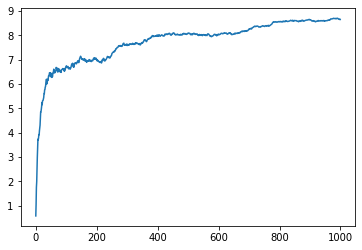

In [7]:
import pandas as pd

pd.Series(np.cumsum(regrets)).plot()

## 2. LinUCB Class Implementation w/ env contained (June, 2021)

In [8]:
class LinUCB:
  def __init__(self, k, d, t, alpha, seed):
    self.k = k 
    self.d = d
    self.t = t
    self.alpha = alpha
    self.seed = seed

    self.opt_theta = np.random.rand(d)*2-1

  def init_matrix(self):
    identity_matrix = []
    for row in range(self.d):
      identity_matrix.append([1 if row==i else 0 for i in range(self.d)])

    identity_matrix = np.array(identity_matrix,dtype=np.float)
    zero_vector = np.zeros((self.d,1))

    return identity_matrix, zero_vector

  def generate_features(self, idx):
    np.random.seed(self.seed+idx)
    result = np.array([np.random.random(self.d) for i in range(self.k)]).transpose()
    return result

  def get_reward(self, obs, arm):
    return obs[:,arm].reshape(1,-1).dot(self.opt_theta)

  def pulling_arms(self, observations, A, est_theta):
    list_est = []
    list_opt = []
    
    for a in range(self.k):
      X_ = observations[:,a].reshape(-1,1)
      est_p = est_theta.T.dot(X_) + self.alpha * np.sqrt(X_.T.dot(np.linalg.inv(A)).dot(X_))
      opt_p = self.opt_theta.T.dot(X_) + self.alpha * np.sqrt(X_.T.dot(np.linalg.inv(A)).dot(X_))

      list_est.append(est_p.item())
      list_opt.append(opt_p.item())

    est_arm = np.argmax(list_est)
    opt_arm = np.argmax(list_opt)

    return est_arm, opt_arm

  def predict(self):
    A,b = self.init_matrix()

    est_rewards = list()
    opt_rewards = list()

    regrets = list()

    for t in range(self.t):
      est_theta = np.linalg.inv(A).dot(b)
      observations = self.generate_features(t)
      
      est_arm, opt_arm = self.pulling_arms(observations, A, est_theta)

      est_reward = self.get_reward(observations, est_arm)
      opt_reward = self.get_reward(observations, opt_arm)

      A += observations[:,est_arm].reshape(-1,1).dot(observations[:,est_arm].reshape(1,-1)) 
      b += (observations[:,est_arm] * est_reward).reshape(-1,1)

      regrets.append(observations[:,opt_arm].reshape(1,-1).dot(self.opt_theta)-observations[:,est_arm].reshape(1,-1).dot(est_theta))

      print(f"Iter:{t+1} | Reward: EST:{est_reward.item():.4f}/OPT:{opt_reward.item():.4f} | Regret:{sum(regrets).item():.4f}")

    self.regret = regrets

  def plot_regret(self):
    pd.Series(np.cumsum(self.regret)).plot()

Streaming output truncated to the last 5000 lines.
Iter:5001 | Reward: EST:0.1488/OPT:0.1488 | Regret:9.3588
Iter:5002 | Reward: EST:0.3015/OPT:0.3015 | Regret:9.3600
Iter:5003 | Reward: EST:0.0959/OPT:0.0959 | Regret:9.3592
Iter:5004 | Reward: EST:0.0422/OPT:0.0422 | Regret:9.3586
Iter:5005 | Reward: EST:0.5260/OPT:0.5260 | Regret:9.3612
Iter:5006 | Reward: EST:-0.0563/OPT:-0.0563 | Regret:9.3589
Iter:5007 | Reward: EST:0.2274/OPT:0.2274 | Regret:9.3591
Iter:5008 | Reward: EST:0.3903/OPT:0.3903 | Regret:9.3608
Iter:5009 | Reward: EST:0.2835/OPT:0.2835 | Regret:9.3620
Iter:5010 | Reward: EST:0.2236/OPT:0.2340 | Regret:9.3725
Iter:5011 | Reward: EST:-0.1471/OPT:-0.1471 | Regret:9.3709
Iter:5012 | Reward: EST:0.0878/OPT:0.0878 | Regret:9.3708
Iter:5013 | Reward: EST:0.2836/OPT:0.2836 | Regret:9.3709
Iter:5014 | Reward: EST:0.1721/OPT:0.1721 | Regret:9.3709
Iter:5015 | Reward: EST:0.1298/OPT:0.1298 | Regret:9.3708
Iter:5016 | Reward: EST:0.2986/OPT:0.2986 | Regret:9.3716
Iter:5017 | Rewar

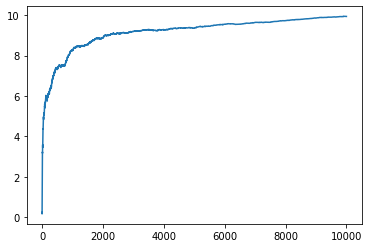

In [9]:
K = 10
D = 5
T = 10000
GLOBAL_SEED = 100
alpha = 0.5


linucb = LinUCB(K,D,T,alpha,GLOBAL_SEED)
linucb.predict()
linucb.plot_regret()

## 3. LinUCB Class Implementation env seperated (July, 2021)

In [10]:
class Env:
  def __init__(self, k, d, norm=None, random_state=None):
    self.k = k
    self.d = d
    self.norm = norm

    self.seed_initialization(random_state)
    self.true_theta = self.init_theta()

  def init_theta(self):
    if self.norm is not None:
      return normalize(np.random.random((self.d,1)), norm=self.norm, axis=0)
    else:
      return np.random.random((self.d,1))

  def get_observations(self):
    if self.norm is not None:
      return normalize(np.hstack([np.random.random((self.d,1)) for i in range(self.k)]), norm=self.norm, axis=0)
    else:
      return np.hstack([np.random.random((self.d,1)) for i in range(self.k)])

  def seed_initialization(self, random_state):
    np.random.seed(random_state)

In [11]:
class LinUCB:
  def __init__(self, k, d, t, alpha, norm=None, seed=None):
    self.k = k 
    self.d = d
    self.t = t
    self.alpha = alpha

    self.env = Env(k,d, norm=norm, random_state=seed)
    self.opt_theta = self.env.true_theta

  def init_matrix(self):
    
    identity_matrix = np.eye(self.d)
    zero_vector = np.zeros((self.d,1))

    return identity_matrix, zero_vector

  def get_reward(self, obs, arm):
    return obs[:,arm].reshape(1,-1).dot(self.opt_theta)

  def pulling_arms(self, observations, A, est_theta):
    list_est = []
    list_opt = []
    
    for a in range(self.k):
      X_ = observations[:,a].reshape(-1,1)
      est_p = est_theta.T.dot(X_) + self.alpha * np.sqrt(X_.T.dot(np.linalg.inv(A)).dot(X_))
      opt_p = self.opt_theta.T.dot(X_) + self.alpha * np.sqrt(X_.T.dot(np.linalg.inv(A)).dot(X_))

      list_est.append(est_p.item())
      list_opt.append(opt_p.item())

    est_arm = np.argmax(list_est)
    opt_arm = np.argmax(list_opt)

    return est_arm, opt_arm

  def predict(self):
    A,b = self.init_matrix()

    est_rewards = list()
    opt_rewards = list()

    regrets = list()

    for t in range(self.t):
      est_theta = np.linalg.inv(A).dot(b)
      observations = self.env.get_observations()
      
      est_arm, opt_arm = self.pulling_arms(observations, A, est_theta)

      est_reward = self.get_reward(observations, est_arm)
      opt_reward = self.get_reward(observations, opt_arm)

      A += observations[:,est_arm].reshape(-1,1).dot(observations[:,est_arm].reshape(1,-1)) 
      b += (observations[:,est_arm] * est_reward).reshape(-1,1)

      regrets.append(observations[:,opt_arm].reshape(1,-1).dot(self.opt_theta)-observations[:,est_arm].reshape(1,-1).dot(est_theta))

      print(f"Iter:{t+1} | Reward: EST:{est_reward.item():.4f}/OPT:{opt_reward.item():.4f} | Regret:{sum(regrets).item():.4f}")

    self.regret = regrets

  def plot_regret(self, figsize=[12,6]):
    fig, axes = plt.subplots(1,2,figsize=figsize)
    pd.Series(np.cumsum(self.regret)).plot(ax=axes[0])
    axes[0].set_title(f"Cummulative Regret for {self.t} iteration")
    pd.Series(np.hstack(self.regret).reshape(-1)).plot(ax=axes[1])
    axes[1].set_title(f"Individual Regret for {self.t} iteration")
    plt.suptitle(f"Regret for Thompson Sampling K={self.k};D={self.d};T={self.t};alpha={self.alpha}")

without l2 normalization

In [12]:
K = 10
D = 5
T = 10000
GLOBAL_SEED = 100
norm = None
alpha = 0.5


linucb = LinUCB(K,D,T,alpha,norm,GLOBAL_SEED)
linucb.predict()

Streaming output truncated to the last 5000 lines.
Iter:5001 | Reward: EST:1.8859/OPT:1.8859 | Regret:10.8126
Iter:5002 | Reward: EST:1.6218/OPT:1.6218 | Regret:10.8136
Iter:5003 | Reward: EST:1.5824/OPT:1.5824 | Regret:10.8138
Iter:5004 | Reward: EST:1.4952/OPT:1.4952 | Regret:10.8140
Iter:5005 | Reward: EST:1.3167/OPT:1.3167 | Regret:10.8137
Iter:5006 | Reward: EST:1.7710/OPT:1.7710 | Regret:10.8140
Iter:5007 | Reward: EST:1.5661/OPT:1.5661 | Regret:10.8145
Iter:5008 | Reward: EST:1.4773/OPT:1.4773 | Regret:10.8145
Iter:5009 | Reward: EST:1.7279/OPT:1.7279 | Regret:10.8152
Iter:5010 | Reward: EST:1.4230/OPT:1.4230 | Regret:10.8151
Iter:5011 | Reward: EST:1.7726/OPT:1.7726 | Regret:10.8147
Iter:5012 | Reward: EST:1.7558/OPT:1.7558 | Regret:10.8143
Iter:5013 | Reward: EST:1.6032/OPT:1.6032 | Regret:10.8148
Iter:5014 | Reward: EST:1.7700/OPT:1.7700 | Regret:10.8151
Iter:5015 | Reward: EST:1.6714/OPT:1.6714 | Regret:10.8152
Iter:5016 | Reward: EST:1.4384/OPT:1.4384 | Regret:10.8154
Iter:

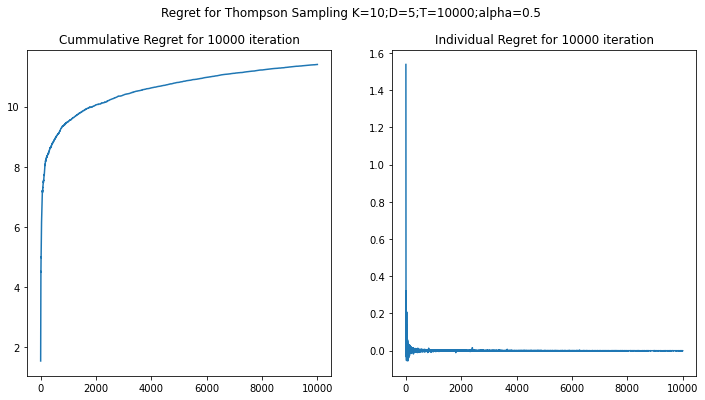

In [13]:
linucb.plot_regret()

with l2 normalization

In [14]:
K = 10
D = 5
T = 10000
GLOBAL_SEED = 100
norm = "l2"
alpha = 0.5


linucb = LinUCB(K,D,T,alpha,norm,GLOBAL_SEED)
linucb.predict()

Streaming output truncated to the last 5000 lines.
Iter:5001 | Reward: EST:0.9458/OPT:0.9458 | Regret:11.1092
Iter:5002 | Reward: EST:0.9385/OPT:0.9385 | Regret:11.1099
Iter:5003 | Reward: EST:0.8741/OPT:0.8741 | Regret:11.1095
Iter:5004 | Reward: EST:0.8168/OPT:0.8168 | Regret:11.1092
Iter:5005 | Reward: EST:0.9103/OPT:0.9103 | Regret:11.1096
Iter:5006 | Reward: EST:0.9132/OPT:0.9132 | Regret:11.1095
Iter:5007 | Reward: EST:0.9620/OPT:0.9620 | Regret:11.1096
Iter:5008 | Reward: EST:0.9657/OPT:0.9657 | Regret:11.1098
Iter:5009 | Reward: EST:0.9594/OPT:0.9594 | Regret:11.1101
Iter:5010 | Reward: EST:0.8693/OPT:0.8693 | Regret:11.1099
Iter:5011 | Reward: EST:0.9052/OPT:0.9052 | Regret:11.1099
Iter:5012 | Reward: EST:0.9837/OPT:0.9837 | Regret:11.1104
Iter:5013 | Reward: EST:0.9230/OPT:0.9230 | Regret:11.1104
Iter:5014 | Reward: EST:0.9741/OPT:0.9741 | Regret:11.1110
Iter:5015 | Reward: EST:0.8889/OPT:0.8889 | Regret:11.1110
Iter:5016 | Reward: EST:0.9138/OPT:0.9138 | Regret:11.1108
Iter:

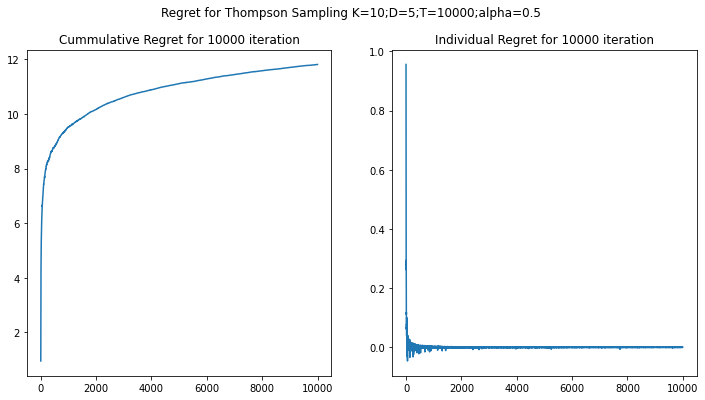

In [15]:
linucb.plot_regret()